In [11]:
! pip install colorcet
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import itertools
import time
from numpy.fft import fft2, ifft2
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
import colorcet as cc 
sns.set_context("talk")

In [2]:
# === EXECUTE THIS CELL ===

def allen_cahn_circular(M, kappa, A, B):
    # === Simulation Parameters ===
    N = 64
    dx = dy = 0.5
    dt = 0.005
    nsteps = 12000

    # === Wavenumber grid ===
    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(N, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2

    # === Free energy derivative ===
    def dfdeta(etas, eta_i):
        sum_eta_sq = np.sum(etas**2, axis=0) - eta_i**2
        return A * (2.0 * B * eta_i * sum_eta_sq + eta_i**3 - eta_i)

    # === Circular Two-Grain Initialization ===
    def init_circular_two_grains(Nx, Ny):
        ngrain = 2
        etas = np.zeros((ngrain, Nx, Ny))
        glist = np.ones(ngrain, dtype=bool)

        x0, y0 = Nx / 2, Ny / 2
        radius = 14.0

        for i in range(Nx):
            for j in range(Ny):
                dist = np.sqrt((i - x0) ** 2 + (j - y0) ** 2)
                if dist <= radius:
                    etas[1, i, j] = 1.0  # Circular grain
                else:
                    etas[0, i, j] = 1.0  # Matrix
        return etas, ngrain, glist

    # === Initialize microstructure ===
    etas, ngrains, glist = init_circular_two_grains(N, N)

    # === Pandas DataFrame to store area fraction evolution ===
    area_records = []

    # === Precompute snapshot steps
    snapshot_steps = [1, int(0.2 * nsteps), int(0.4 * nsteps), int(0.6 * nsteps), int(0.8 * nsteps), nsteps]

    # === Time-stepping loop ===
    start_time = time.time()
    for step in range(1, nsteps + 1):
        for ig in range(ngrains):
            if not glist[ig]:
                continue
            eta = etas[ig]
            dfdeta_real = dfdeta(etas, eta)
            dfdeta_hat = fft2(dfdeta_real)

            # Semi-implicit spectral update
            eta_hat = fft2(eta)
            eta_hat = (eta_hat - dt * M * dfdeta_hat) / (1 + dt * M * kappa * K2)
            eta = np.clip(ifft2(eta_hat).real, 0.00001, 0.9999)
            etas[ig] = eta

        # Compute area fraction of the shrinking grain (grain index 1)
        mask = etas[1] >= 0.5
        area_fraction = np.sum(mask) / (N * N)
        area_records.append({'time': step * dt, 'area_fraction': area_fraction})

        # Plot snapshots at key steps
        if step in snapshot_steps:
            eta2 = np.sum(etas**2, axis=0)
            plt.figure(figsize=(2, 2))
            plt.imshow(eta2, cmap='viridis')
            plt.title(f'Step {step}')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    total_time = time.time() - start_time
    print(f"Total compute time: {total_time:.2f} seconds")

    # === Convert to DataFrame ===
    area_df = pd.DataFrame(area_records)

    # === Plot the grain area evolution ===
    # === Stacked bar chart: shrinking grain + growing matrix ===
    area_df['matrix_fraction'] = 1.0 - area_df['area_fraction']

    # Plot every nth frame to keep the bar chart from being too dense
    stride = max(1, len(area_df) // 100)  # max 100 bars
    sampled_df = area_df.iloc[::stride].reset_index(drop=True)

    times = sampled_df['time']
    grain = sampled_df['area_fraction']
    matrix = sampled_df['matrix_fraction']

    fig, ax = plt.subplots(figsize=(3, 5))
    ax.bar(times, matrix, label='Matrix Grain', color='#FDE725')
    ax.bar(times, grain, bottom=matrix, label='Shrinking Grain', color='#20908c')

    ax.set_xlabel('Time')
    ax.set_ylabel('Area Fractions')

    ax.set_ylim(0, 1)
    ax.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

    return

In [3]:
# === EXECUTE THIS CELL, TOO===

def allen_cahn_voronoi(M, kappa, A=1, B=1, ngrains=25, rng_seed=1234):
    # === Fixed Simulation Parameters ===
    N = 64
    dx = dy = 0.5
    nsteps = 10000
    dt = 0.005
    smoothing_sigma = 1.5
    snapshot_interval = 100

    # === Wavenumber grid ===
    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(N, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2

    def dfdeta(etas, eta_i):
        sum_eta_sq = np.sum(etas**2, axis=0) - eta_i**2
        return A * (2.0 * B * eta_i * sum_eta_sq + eta_i**3 - eta_i)

    def procedural_voronoi_smoothed(Nx, Ny, ngrains, sigma):
        np.random.seed(rng_seed)
        points = np.random.rand(ngrains, 2) * [Nx, Ny]
        tree = cKDTree(points)
        x = np.arange(Nx) + 0.5
        y = np.arange(Ny) + 0.5
        X, Y = np.meshgrid(x, y, indexing='ij')
        grid_points = np.stack((X.ravel(), Y.ravel()), axis=-1)
        _, grain_ids = tree.query(grid_points)
        grain_map = grain_ids.reshape(Nx, Ny)

        etas = np.zeros((ngrains, Nx, Ny))
        for i in range(ngrains):
            etas[i] = (grain_map == i).astype(float)

        etas_smoothed = gaussian_filter(etas, sigma=(0, sigma, sigma))
        etas_smoothed /= np.sum(etas_smoothed, axis=0, keepdims=True)
        return etas_smoothed, ngrains, np.ones(ngrains, dtype=bool), grain_map

    etas, ngrains, glist, grain_map = procedural_voronoi_smoothed(N, N, ngrains, smoothing_sigma)

    area_fraction_records = []

    def show_microstructure(etas, step, event=""):
        eta2 = np.sum(etas**2, axis=0)
        plt.figure(figsize=(2.5, 2.5))
        plt.imshow(eta2, cmap='viridis', vmin=0.0, vmax=1.0)
        plt.title(f'{event}\nStep {step}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    start_time = time.time()
    show_microstructure(etas, step=0, event="Initial")

    for step in range(1, nsteps + 1):
        for ig in range(ngrains):
            if not glist[ig]:
                continue
            eta = etas[ig]
            dfdeta_real = dfdeta(etas, eta)
            dfdeta_hat = fft2(dfdeta_real)
            eta_hat = fft2(eta)
            eta_hat = (eta_hat - dt * M * dfdeta_hat) / (1 + dt * M * kappa * K2)
            eta = np.clip(ifft2(eta_hat).real, 0.00001, 0.9999)
            etas[ig] = eta

            if np.sum(eta) / (N * N) <= 0.001:
                glist[ig] = False
                etas[ig] = 0.0
                show_microstructure(etas, step=step, event=f"Grain {ig+1} eliminated")

        # Store area fractions
        if step % snapshot_interval == 0 or step == 1:
            fractions = [np.sum(etas[ig]) / (N * N) if glist[ig] else 0.0 for ig in range(ngrains)]
            record = {'time': step * dt}
            for ig in range(ngrains):
                record[f'grain_{ig+1}'] = fractions[ig]
            area_fraction_records.append(record)

    total_time = time.time() - start_time
    print(f"\nTotal compute time: {total_time:.2f} seconds")

    # === Convert to DataFrame ===
    area_df = pd.DataFrame(area_fraction_records)

    # === Stacked bar chart for grain areas ===
    area_df_bar = area_df.copy()
    time_values = area_df_bar['time']
    grain_cols = [col for col in area_df_bar.columns if col.startswith('grain_')]
    fractions = area_df_bar[grain_cols].values

    # Sample time points to reduce visual clutter
    stride = max(1, len(area_df_bar) // 100)
    sampled_time = time_values[::stride].values
    sampled_fractions = fractions[::stride]

    data = np.array(sampled_fractions).T  # shape: [ngrains, time]
    colors = cc.glasbey[:len(grain_cols)]  # Get Glasbey colors

    fig, ax = plt.subplots(figsize=(12, 5))
    bottom = np.zeros_like(sampled_time)
    for i, row in enumerate(data):
        ax.bar(sampled_time, row, bottom=bottom,
               width=0.8 * (sampled_time[1] - sampled_time[0]),
               color=colors[i], label=f'Grain {i+1}')
        bottom += row

    ax.set_xlabel('Time')
    ax.set_ylabel('Area Fraction')

    #ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=2, fontsize=8, title="Grains")
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()

# Exercise: Allen-Cahn and Grain Growth
## Shrinkage of a circular grain

The program solves the non-conserved multi-component Allen–Cahn equation.
The free energy density is coded as:
$$
f(\eta_1,\eta_2, \ldots, \eta_N) = \sum_{i=1}^N \left( - \frac{A}{2} \eta_i^2 + \frac{B}{4} \eta_i^4 + \sum_{i=1}^N \sum_{j\neq i}^N \eta_i^2\eta_j^2 \right).
$$

The function $f(\eta_1,\eta_2) = -0.5\eta_1^2 + 0.25\eta_1^4 - 0.5\eta_2^2 + 0.25\eta_2^4 + 2\eta_1^2\eta_2^2$ has four minima at 
$$
(\eta_1, \eta_2) = (0,1), (1,0), (-1,0), (0,-1)
$$
however, in this simulation $\eta_1$ and $\eta_2$ take only the values of $0$ and $1$ (cf. p. 36 in *Programming Phase-Field Modeling* by S. Bulent Biner).

### Task (a)

Define the local free energy functional for $A = B = 1$ as a function of two order parameters, $\eta_1$ and $\eta_2$ and execute the cell. Discuss the physical meaning of this free energy density in the context of grain growth.

The region of interest in the energy landscape ($\eta_1, \eta_2 \in \{0, 1\}$) is marked with a white square.

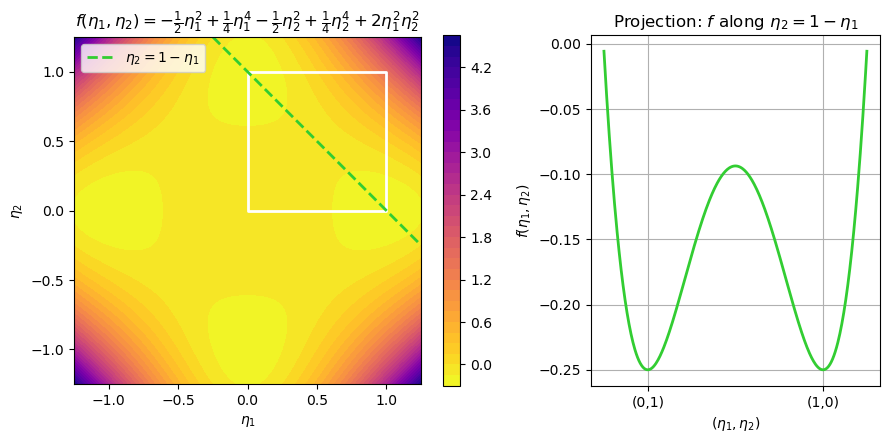

In [4]:
# COMPLETE AND EXECUTE THIS CELL

def f(eta1, eta2):
    return (
        -0.5 * eta1**2 + 0.25 * eta1**4
        - 0.5 * eta2**2 + 0.25 * eta2**4
        + 2 * eta1**2 * eta2**2
    )

# Prepare grid for contour plot
eta1 = np.linspace(-1.25, 1.25, 400)
eta2 = np.linspace(-1.25, 1.25, 400)
ETA1, ETA2 = np.meshgrid(eta1, eta2)
Z = f(ETA1, ETA2)

# Line for projection: from (0,1) to (1,0)
t = np.linspace(-0.25, 1.25, 400)
eta1_line = t
eta2_line = 1 - t
z_line = f(eta1_line, eta2_line)

# Create the figure and set up side-by-side plots
fig = plt.figure(figsize=(9, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])

# === Left: Contour Plot ===
ax0 = plt.subplot(gs[0])
contour = ax0.contourf(ETA1, ETA2, Z, levels=45, cmap='plasma_r')
plt.colorbar(contour, ax=ax0)
ax0.set_xlabel(r'$\eta_1$')
ax0.set_ylabel(r'$\eta_2$')
ax0.set_title(r'$f(\eta_1,\eta_2) = -\frac{1}{2}\eta_1^2 + \frac{1}{4}\eta_1^4 - \frac{1}{2}\eta_2^2 + \frac{1}{4}\eta_2^4 + 2\eta_1^2\eta_2^2$')

# Ensure square plot area
ax0.set_aspect('equal')

# Overlay the square
square = np.array([[0, 1], [1, 1], [1, 0], [0, 0], [0, 1]])
ax0.plot(square[:, 0], square[:, 1], color='white', linewidth=2)

# Highlight the projection line
ax0.plot(eta1_line, eta2_line, color='limegreen', linestyle='--', linewidth=2, label=r'$\eta_2 = 1 - \eta_1$')
ax0.legend(loc='upper left')

# === Right: 1D Projection Plot ===
ax1 = plt.subplot(gs[1])
ax1.plot(t, z_line, color='limegreen', linewidth=2)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['(0,1)', '(1,0)'])
ax1.set_xlabel(r'$(\eta_1, \eta_2)$')
ax1.set_ylabel(r'$f(\eta_1, \eta_2)$')
ax1.set_title(r'Projection: $f$ along $\eta_2 = 1 - \eta_1$')
ax1.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">

The function $f(\eta_1,\eta_2) = -0.5\eta_1^2 + 0.25\eta_1^4 - 0.5\eta_2^2 + 0.25\eta_2^4 + 2\eta_1^2\eta_2^2$ has four minima at 
$$
(\eta_1, \eta_2) = (0,1), (1,0), (-1,0), (0,-1)
$$

however, in this simulation $\eta_1$ and $\eta_2$ take only the values of 0 and 1.

The region of interest in the energy landscape is marked with a white square.


If we take the projection of $f(\eta_1,\eta_2)$ on the plane that connects (0,1) and (1,0), we find the familiar double-well free energy curve, where the two minima correspond to this depiction of two grains separated by a grain boundary located at $x=0$:

Compare your explanation to the following figure:

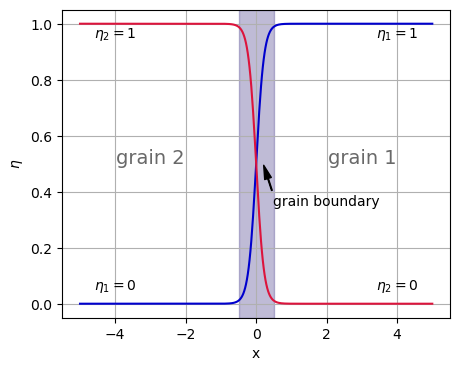

In [5]:
# EXECUTE THIS CELL

# Define the x range
x = np.linspace(-5, 5, 400)

# Set up the plot
plt.figure(figsize=(5, 4))

y = 0.5 + np.tanh(x) / 2

plt.plot(x, 0.5 + np.tanh(4.5 * x) / 2, color='mediumblue')
plt.plot(x, 0.5 + np.tanh(-4.5 * x) / 2, color='crimson')

plt.axvspan(-0.5, 0.5, color='darkslateblue', alpha=0.35, zorder=0)

plt.text(-4, 0.05, r"$\eta_1 = 0$", horizontalalignment='center')
plt.text(-4, 0.95, r"$\eta_2 = 1$", horizontalalignment='center')

plt.text(4, 0.05, r"$\eta_2 = 0$", horizontalalignment='center')
plt.text(4, 0.95, r"$\eta_1 = 1$", horizontalalignment='center')

plt.text(-3, 0.5, r"grain 2", horizontalalignment='center', color="dimgrey", fontsize=14)
plt.text(3, 0.5, r"grain 1", horizontalalignment='center', color="dimgrey", fontsize=14)

plt.annotate("grain boundary", xy=(0.2, 0.5), xytext=(2, 0.35),
             arrowprops=dict(facecolor='black', width=0.5, headwidth=5, headlength=10, shrink=0.05),
            color='black', horizontalalignment='center')

# Add labels and legend
plt.xlabel('x')
plt.ylabel(r'$\eta$')

#plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Task (b)

We simulate the shrinkage of a grain embedded within a larger grain. As the smaller grain shrinks, the surrounding matrix grain grows correspondingly.

Run the program using a mobility of $M = 4.0$ and a gradient energy coefficient of $\kappa = 0.1$.

The simulation outputs snapshots that illustrate the time evolution of the microstructure, along with a final plot showing the area fractions of both the embedded grain and the matrix grain as functions of time.

Why do the areas decrease proportionally to time, i.e., why is $A(t) \propto t$?

> **Hint**: The velocity $v$ of the grain boundary is given by:
> $$
>v = \frac{dr}{dt} = M \gamma \frac{2}{r},
>$$
>
>where $r$ is the radius of the grain, $\gamma$ is the grain boundary energy and $M$ is the grain boundary mobility.

<div class="alert alert-info" role="alert">

Grain growth or shrinkage is driven by the reduction of grain boundary (interface) energy $\gamma$. 

To find how the grain radius evolves with time, we solve the differential equation:

$$
r\,\frac{dr}{dt} = 2 M \gamma
$$
$$
r\,dr = 2 M \gamma\,dt 
$$
$$
\int_{r_0}^r r\,dr = \int_0^t 2 M \gamma\,dt 
$$
$$
\left. \frac{r^2}{2} \right|_{r_0}^{r} = 2 M \gamma t 
$$
$$
\frac{r^2 - r_0^2}{2} = 2 M \gamma t 
$$
$$
r^2 - r_0^2 = 4 M \gamma t = \kappa t,
$$

where we define $\kappa = 4 M \gamma$ as a temperature-dependent constant (via an Arrhenius relation for $M$).


The area of the circular grain is given by:

$$
A(t) = \pi r^2(t).
$$

Using the result above:

$$
A(t) = \pi (r_0^2 + \kappa t).
$$


This shows that the area of the grain increases linearly with time, at a rate proportional to $\kappa = 4 M \gamma$.

In [6]:
import ipywidgets as widgets
from ipywidgets import interact

interact(
    allen_cahn_circular,
    M=widgets.FloatSlider(value=4.0, min=1, max=10.0, step=0.5, description='Mobility (M)'),
    kappa=widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.1, description='Gradient coefficient (κ)'),
    A=widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='A'),
    B=widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='B')
);

interactive(children=(FloatSlider(value=4.0, description='Mobility (M)', max=10.0, min=1.0, step=0.5), FloatSl…

#### Task (c)

Run the program using: 
- a mobility of $2.0$ and a gradient coefficient of $0.1$,
- a mobility of $2.0$ and a gradient coefficient of $0.2$,

and compare the results with the previous task.
How do the mobility and the gradient term affect the result ? 

> **Hint:** To avoid overwriting your previous results, duplicate the relevant code cells and update the values in each copy. This allows you to run multiple simulations sequentially and compare the outcomes.

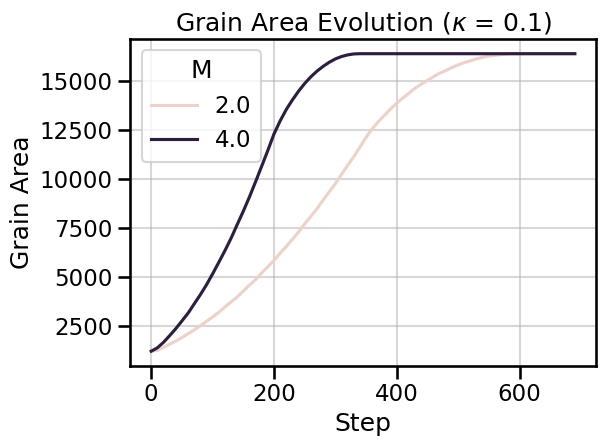

In [13]:
def allen_cahn_circular_loop():
    # Parameters
    A = 1.0
    B = 1.0
    N = 128
    dx = dy = 1.0
    dt = 0.1
    steps = 700

    X, Y = np.meshgrid(np.linspace(-N/2, N/2, N), np.linspace(-N/2, N/2, N))
    R = np.sqrt(X**2 + Y**2)

    # Create initial circular grain (radius = 20)
    phi0 = np.zeros((N, N), dtype=np.float32)
    phi0[R < 20] = 1.0

    # Gradient operator (Laplacian)
    def laplacian(Z):
        return (
            -4 * Z +
            np.roll(Z, 1, axis=0) + np.roll(Z, -1, axis=0) +
            np.roll(Z, 1, axis=1) + np.roll(Z, -1, axis=1)
        ) / (dx**2)

    results = []

    for M in [4.0, 2.0]:
        kappa = 0.1
        phi = phi0.copy()
        area_series = []

        for step in range(steps):
            lap_phi = laplacian(phi)
            dF_dphi = -A * phi + B * phi**3 - kappa * lap_phi
            phi -= M * dt * dF_dphi

            if step % 10 == 0:
                area = np.sum(phi > 0.5) * dx * dy
                area_series.append({'step': step, 'M': M, 'area': area})

        results.extend(area_series)

    df = pd.DataFrame(results)
    sns.lineplot(data=df, x='step', y='area', hue='M')
    plt.xlabel('Step')
    plt.ylabel('Grain Area')
    plt.title(r'Grain Area Evolution ($\kappa$ = 0.1)')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

allen_cahn_circular_loop()

<div class="alert alert-info" role="alert">

Above, simulations with the same gradient term but different mobilities are compared: as expected, the system with higher mobility evolves faster. 

Below, systems with the same mobility but different gradient terms are compared: the system with the higher gradient term evolves faster because the penalty associated with interfaces is higher (both the interface width and the interface energy scale with $\sqrt k$), and therefore, the driving force to minimize interfaces is greater.

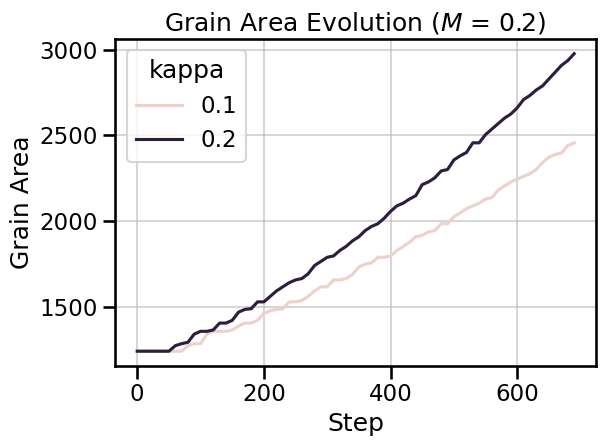

In [14]:
def allen_cahn_circular_loop():
    # Parameters
    A = 1.0
    B = 1.0
    N = 128
    dx = dy = 1.0
    dt = 0.1
    steps = 700

    X, Y = np.meshgrid(np.linspace(-N/2, N/2, N), np.linspace(-N/2, N/2, N))
    R = np.sqrt(X**2 + Y**2)

    # Create initial circular grain (radius = 20)
    phi0 = np.zeros((N, N), dtype=np.float32)
    phi0[R < 20] = 1.0

    # Gradient operator (Laplacian)
    def laplacian(Z):
        return (
            -4 * Z +
            np.roll(Z, 1, axis=0) + np.roll(Z, -1, axis=0) +
            np.roll(Z, 1, axis=1) + np.roll(Z, -1, axis=1)
        ) / (dx**2)

    results = []

    for kappa in [0.1, 0.2]:
        M = 0.2
        phi = phi0.copy()
        area_series = []

        for step in range(steps):
            lap_phi = laplacian(phi)
            dF_dphi = -A * phi + B * phi**3 - kappa * lap_phi
            phi -= M * dt * dF_dphi

            if step % 10 == 0:
                area = np.sum(phi > 0.5) * dx * dy
                area_series.append({'step': step, 'kappa': kappa, 'area': area})

        results.extend(area_series)

    df = pd.DataFrame(results)
    sns.lineplot(data=df, x='step', y='area', hue='kappa')
    plt.xlabel('Step')
    plt.ylabel('Grain Area')
    plt.title(r'Grain Area Evolution ($M$ = 0.2)')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

allen_cahn_circular_loop()

## Ripening of Voronoi microstructure

### Task (d) 

Run the simulation with the following parameters. Observe the microstructure evolution and grain growth behavior.

   * Mobility: $5.0$
   * Gradient coefficient: $0.8$
   * Number of grains: $25$

**The simulation takes a couple of minutes to run on Colab. It completes when the plot of the area fractions appears.**

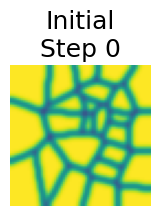

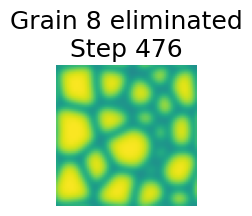

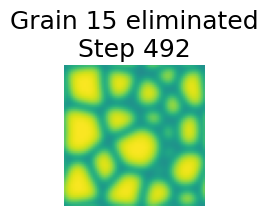

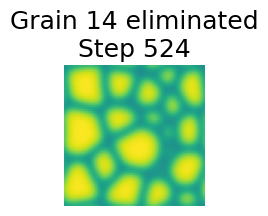

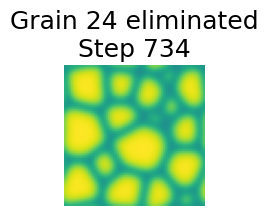

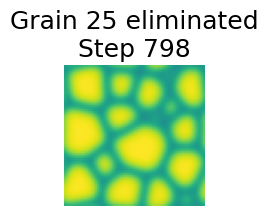

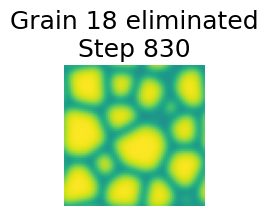

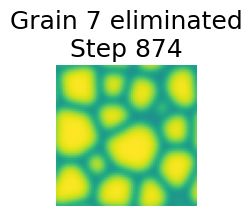

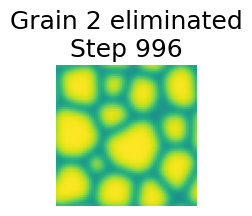

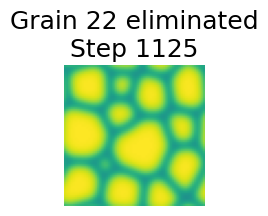

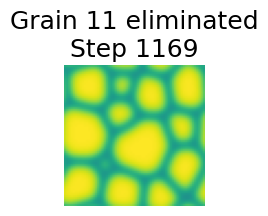

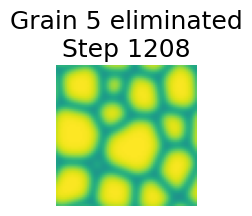

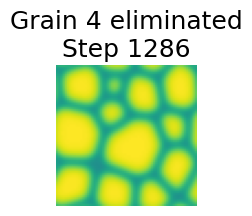

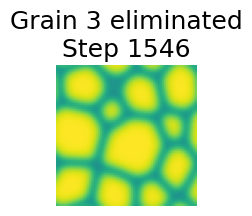

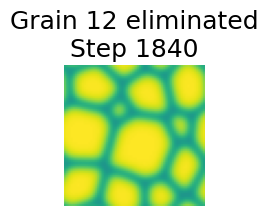

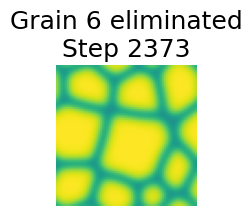

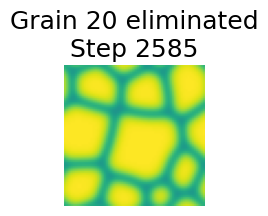

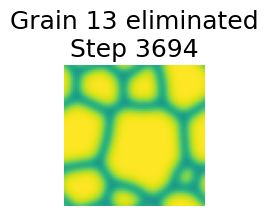

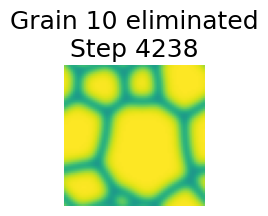

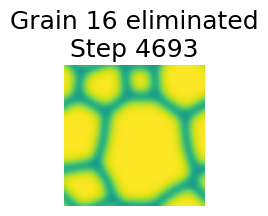

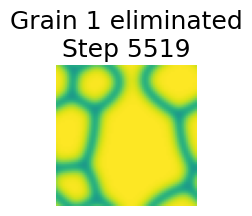

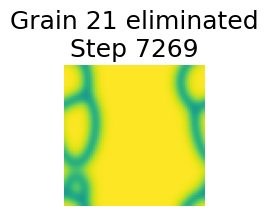

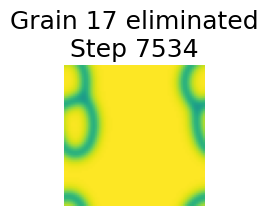

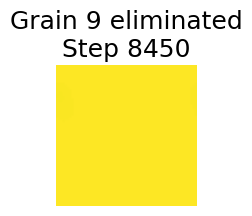

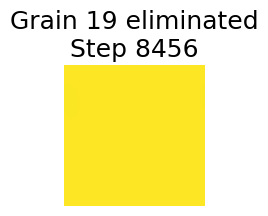


Total compute time: 27.91 seconds


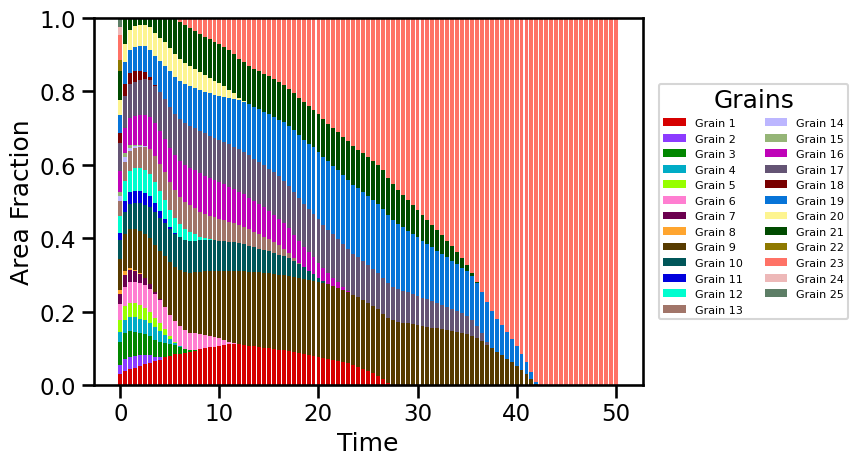

In [17]:
allen_cahn_voronoi(5.0, 0.8, 1.0, 1.0, 25, 1234)

### Task (e) 
Change the gradient coefficient to $0.2$. How does the reduction in the gradient energy term affect the microstructure and its time evolution?

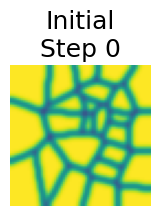

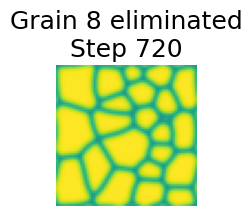

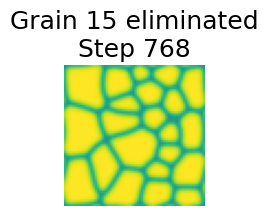

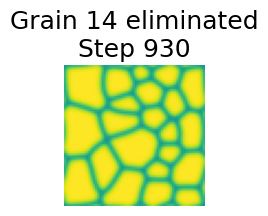

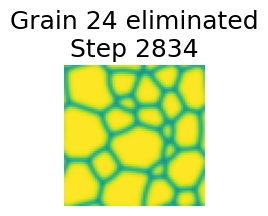

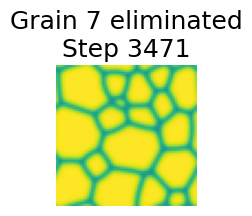

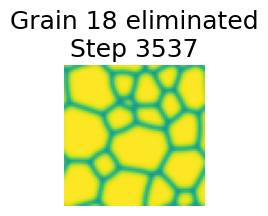

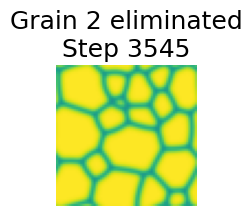

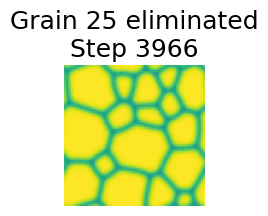

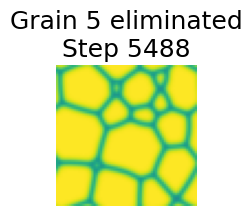

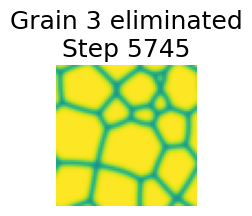

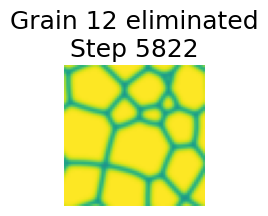

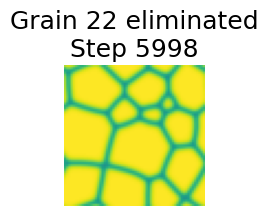

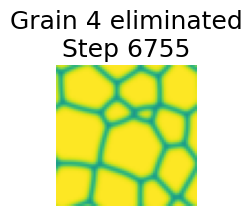

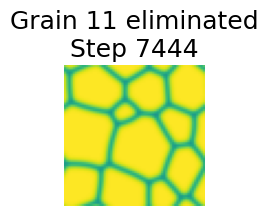

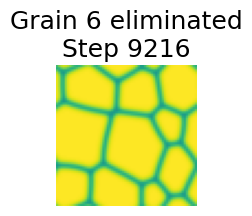


Total compute time: 49.40 seconds


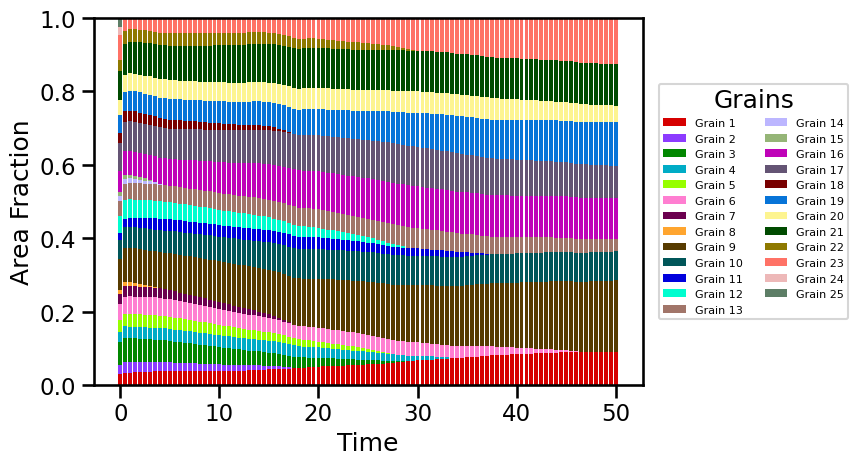

In [ ]:
allen_cahn_voronoi(5.0, 0.2, 1.0, 1.0, 25, 1234)

### Task (f) 
Now set the number of grains to $2$. Explain the result.

> **Hint:** To avoid overwriting your previous results, duplicate the relevant code cells and update the values in each copy. This allows you to run multiple simulations sequentially and compare the outcomes.

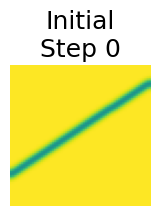


Total compute time: 5.84 seconds


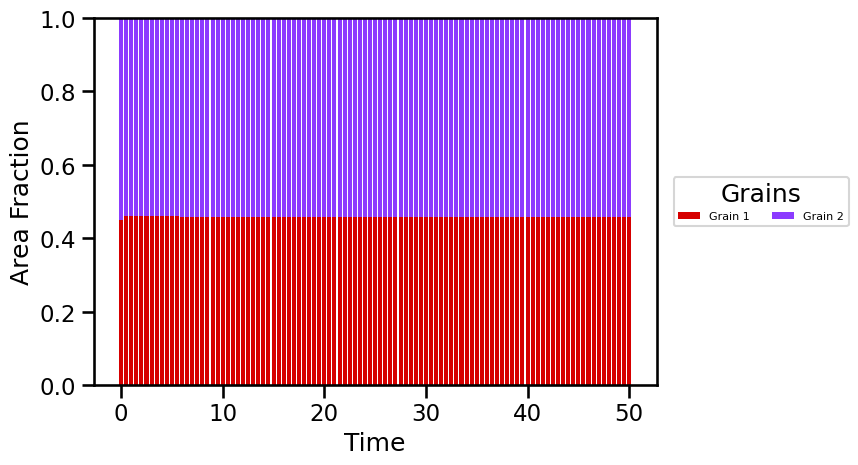

In [18]:
allen_cahn_voronoi(5.0, 0.2, 1.0, 1.0, 2, 1234)

<div class="alert alert-info" role="alert">

Grain growth or shrinkage is driven by the reduction of grain boundary (interface) energy, denoted by $\gamma$. The normal velocity $v$ of a grain boundary is given by:

$$
v = \frac{dr}{dt} = M \gamma \frac{2}{r},
$$

where $r$ is the local radius of curvature of the grain boundary, $\gamma$ is the grain boundary energy, and $M$ is the grain boundary mobility.

Regions with high curvature (i.e., small $r$), such as small convex grains, experience a stronger driving force to shrink because they have a higher grain boundary area relative to their volume, leading to faster boundary motion.

A perfectly flat interface has infinite radius of curvature ($r \to \infty$), resulting in zero curvature. In this case, there is no driving force for grain boundary motion, and thus no spontaneous grain growth.
</div>